## Library import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import numpy as np
from matplotlib import font_manager, rc
from tqdm import tqdm
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

## Data load

In [2]:
data = pd.read_csv('C:/Users/user/Desktop/DACON/jeju_credit_card/201901-202003.csv')
gc.collect()

7

### Features

'REG_YYMM' : 년월

'CARD_SIDO_NM' : 카드 이용지역_시도(가맹정 기준)

'CARD_CCG_NM' : '카드 이용지역_시군구(가맹점 기준)

'STD_CLSS_NM' : 업종명

'HOM_SIDO_NM' : 거주지역_시도(고객 집주소)

'HOM_CCG_NM' : 거주지역_시군구(고객 집주소)

'AGE' : 나이

'SEX_CTGO_CD' : 성별(1: 남, 2: 여)

'FLC' : 가구 생애 주기 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)

'CSTMR_CNT' : 이용고객수(명)

'AMT' : 이용금액(원)

'CNT' : 이용건수(건)

row : "특정" 날짜, 업종, 고객의 지역, 연령, 성별로 구분되는 그룹. 이 그룹의 이용 고객 수, 이용금액, 이용건수 또한 features로 표현되어 있다.

목적 : 주어지는 test 데이터(2020년 4월(Public), 2020년 7월(Private))를 특정 지역, 업종, 날짜(월)로 그룹화 하고, 해당그룹의 AMT(이용금액)을 예측하는 모델을 만드는 것.

In [3]:
data.columns

Index(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',
       'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'AMT', 'CNT'],
      dtype='object')

# 예측 모형 만들기
### 지역과 업종별로 새롭게 계산한 Cov 변수를 적용하여 예측하기
1. group_city_clss_time, group_city_clss 만들기
2. m1_m4_ratio, cov_ratio 계산하기



1. 20년1월 * (19년4월 / 19년1월) => 예측_20년4월(non_cov)
2. mean(20년2월/19년2월, 20년3월/19년3월) => 예측_con_ratio 
3. 예측_20년4월(non_cov) * 예측_con_ratio  => 예측_20년4월(cov)

## 1. group_city_clss_time, group_city_clss 만들기

* group_city_clss_time : (도시, 업종, 월별)을 기준으로 groupby
* group_city_clss : (도시, 업종)을 기준으로 groupby

### 1) group_city_clss_time

In [3]:
# 데이터를 날짜, 도시, 업종으로 groupby
# 인덱싱을 편하게 하기 위해 row를 CARD_SIDO_NM,	STD_CLSS_NM, REG_YYMM 3개의 level로 표현

group_city_clss_time = data.loc[:, ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]\
                           .groupby(['CARD_SIDO_NM', 'STD_CLSS_NM', 'REG_YYMM'])['AMT']\
                           .sum()

group_city_clss_time = pd.DataFrame(group_city_clss_time)
gc.collect()
# group_data는 'AMT'하나만 column으로 갖는다.
group_city_clss_time = np.log(group_city_clss_time)
group_city_clss_time

AMT
CARD_SIDO_NM STD_CLSS_NM REG_YYMM           
강원           건강보조식품 소매업  201901    18.815117
                         201902    18.804008
                         201903    18.510878
                         201904    18.484111
                         201905    18.813505
...                                      ...
충북           휴양콘도 운영업    201911    18.636740
                         201912    18.754069
                         202001    19.218517
                         202002    17.667483
                         202003    16.359746

[9438 rows x 1 columns]

### 2) group_city_clss

In [4]:
#group_city_clss 만들기
# CARD_SIDO_NM , STD_CLSS_NM으로만 groupby
# REG_YYMM는 모두 통합
group_city_clss = pd.DataFrame(data.loc[:, ['CARD_SIDO_NM',
                          'STD_CLSS_NM',
                          'AMT']].groupby(['CARD_SIDO_NM',
                                          'STD_CLSS_NM'])['AMT'].sum())

group_city_clss['AMT'] = np.log(group_city_clss['AMT'])
group_city_clss = group_city_clss.reset_index() #index를 column에 포함시키기
group_city_clss['m1_m4_ratio'] =  0
group_city_clss['cov_ratio'] = 0
group_city_clss

,CARD_SIDO_NM,STD_CLSS_NM,AMT,m1_m4_ratio,cov_ratio
0,강원,건강보조식품 소매업,21.322555,0,0
1,강원,골프장 운영업,24.660779,0,0
2,강원,과실 및 채소 소매업,23.537206,0,0
3,강원,관광 민예품 및 선물용품 소매업,19.940658,0,0
4,강원,그외 기타 분류안된 오락관련 서비스업,12.083905,0,0
...,...,...,...,...,...
645,충북,피자 햄버거 샌드위치 및 유사 음식점업,23.781699,0,0
646,충북,한식 음식점업,26.513671,0,0
647,충북,호텔업,20.090111,0,0
648,충북,화장품 및 방향제 소매업,22.939802,0,0


## 2. m1_m4_ratio, cov_ratio 계산하기

### 1) m1_m4_ratio, cov_ratio 계산하기

In [5]:
# 지역, 업종별로 코로나 영향을 조사하는 함수
citys = group_city_clss.CARD_SIDO_NM.unique()

i = 0 # row의 index

group_city_clss.iloc[i, 4] =  1# 19년 4월 데이터를 사용

for city in tqdm(citys):
    clsses = group_city_clss[group_city_clss.CARD_SIDO_NM == city].STD_CLSS_NM.unique()
    for clss in clsses:                 
        # m1_m4_ratio 구하기-----------------------------------------------------------------------------------
        '''
        ## 201901, 201904, 202001중 하나라도 없을 경우 m01_m04_ratio 계산이 무의미함
        condition = (201901 not in group_city_clss_time.loc[city, clss].index) or \
                        (201904 not in group_city_clss_time.loc[city, clss].index) or \
                            (202001 not in group_city_clss_time.loc[city, clss].index)
        if condition: # condition이 True일 때는 -1로 채우기
            group_city_clss.iloc[i, 3] =  -1
            
        else: # 모든 데이터가 다 있을 때, m01_m04_ratio를 계산
            m01_m04_ratio = group_city_clss_time.loc[city, clss, 201904].values \
                            / group_city_clss_time.loc[city, clss, 201901].values
            group_city_clss.iloc[i, 3] =  m01_m04_ratio
        '''
        # cov_ratio 구하기-----------------------------------------------------------------------------------
        ## 201902, 201903, 202002, 202003 중 하나라도 없을 경우 cov_ratio 계산이 무의미함
        condition = (201902 not in group_city_clss_time.loc[city, clss].index) or \
                        (201903 not in group_city_clss_time.loc[city, clss].index) or \
                            (202002 not in group_city_clss_time.loc[city, clss].index) or \
                                (202003 not in group_city_clss_time.loc[city, clss].index) 
        if condition:
            group_city_clss.iloc[i, 4] =  -1
            
        else:
            m03_m01 = group_city_clss_time.loc[city, clss, 202003].values \
                            / group_city_clss_time.loc[city, clss, 202001].values
            m03_m02 = group_city_clss_time.loc[city, clss, 202003].values \
                            / group_city_clss_time.loc[city, clss, 202002].values
            group_city_clss.iloc[i, 4] =  m03_m01 * m03_m02
        
        # i는 1 증가-----------------------------------------------------------------------------------
        i = i+1
group_city_clss

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.24it/s]


,CARD_SIDO_NM,STD_CLSS_NM,AMT,m1_m4_ratio,cov_ratio
0,강원,건강보조식품 소매업,21.322555,0,0.977674
1,강원,골프장 운영업,24.660779,0,1.096233
2,강원,과실 및 채소 소매업,23.537206,0,0.984784
3,강원,관광 민예품 및 선물용품 소매업,19.940658,0,0.940694
4,강원,그외 기타 분류안된 오락관련 서비스업,12.083905,0,-1.000000
...,...,...,...,...,...
645,충북,피자 햄버거 샌드위치 및 유사 음식점업,23.781699,0,1.003556
646,충북,한식 음식점업,26.513671,0,0.984945
647,충북,호텔업,20.090111,0,0.959424
648,충북,화장품 및 방향제 소매업,22.939802,0,0.979265


### 2) m1_m4_ratio, cov_ratio의 null 채우기

In [6]:
print('cov_ratio가 없는 경우',len(group_city_clss[(group_city_clss['cov_ratio'] == -1)]), '개 /  650 개')
print('m1_m4_ratio가 없는 경우',len(group_city_clss[(group_city_clss['m1_m4_ratio'] == -1)]), '개 /  650 개')

cov_ratio가 없는 경우 49 개 /  650 개
m1_m4_ratio가 없는 경우 0 개 /  650 개


#### i. cov_ratio의 null 값 채우기

In [7]:
group_city_clss[(group_city_clss['STD_CLSS_NM'] == '택시 운송업') ]
## 택시 운송없의 경우 우선 데이터가 많지 않다.
## 또한 지역별로 코로나 변수의 편차가 심하다 -> 어던 지역은 코로나의 영향을 덜 받고, 어떤 지역은 코로나의 영향을 많이 받는다.
#  이 문제를 해결할 방법이 떠오르지 않으므로 그냥 동일 업종의 다른 지역 ratio를 평균해서 구함.

# 이곳의 null값을 채우는 방법 -> 1안 코로나 변수가 존재하는 지역들의 평균
                                # 2안 있는 데이터를 잘 조합하여 생성

,CARD_SIDO_NM,STD_CLSS_NM,AMT,m1_m4_ratio,cov_ratio
34,강원,택시 운송업,14.787391,0,-1.000000
73,경기,택시 운송업,21.641130,0,0.974757
112,경남,택시 운송업,19.512896,0,0.931423
151,경북,택시 운송업,16.060030,0,0.944089
189,광주,택시 운송업,14.033923,0,-1.000000
226,대구,택시 운송업,25.236148,0,0.938120
299,부산,택시 운송업,24.854824,0,0.966712
339,서울,택시 운송업,28.085330,0,0.982865
409,울산,택시 운송업,12.187399,0,-1.000000
447,인천,택시 운송업,21.434219,0,0.981631


In [8]:
none_clsses = group_city_clss[group_city_clss['cov_ratio'] == -1].STD_CLSS_NM.unique()

for none_clss in none_clsses:
    group_city_clss.loc[((group_city_clss.STD_CLSS_NM == none_clss) & (group_city_clss.cov_ratio == -1)),'cov_ratio']\
            = group_city_clss.loc[((group_city_clss.STD_CLSS_NM == none_clss) \
                & (group_city_clss.cov_ratio != -1)),'cov_ratio'].mean()

In [9]:
group_city_clss[group_city_clss['STD_CLSS_NM'] == '택시 운송업']

,CARD_SIDO_NM,STD_CLSS_NM,AMT,m1_m4_ratio,cov_ratio
34,강원,택시 운송업,14.787391,0,0.954314
73,경기,택시 운송업,21.641130,0,0.974757
112,경남,택시 운송업,19.512896,0,0.931423
151,경북,택시 운송업,16.060030,0,0.944089
189,광주,택시 운송업,14.033923,0,0.954314
226,대구,택시 운송업,25.236148,0,0.938120
299,부산,택시 운송업,24.854824,0,0.966712
339,서울,택시 운송업,28.085330,0,0.982865
409,울산,택시 운송업,12.187399,0,0.954314
447,인천,택시 운송업,21.434219,0,0.981631


In [10]:
print('cov_ratio가 없는 경우',len(group_city_clss[(group_city_clss['cov_ratio'] == -1)]), '개 /  650 개')
## 모든 Null 값을 채웠다.

cov_ratio가 없는 경우 0 개 /  650 개


#### ii. m1_m4_ratio의 null 값 채우기

In [12]:
# 같은 방식으로 m1_m4_ratio의 Null 데이터로 채웠다.
# 하지만 2020년 1월 데이터가 없을 경우 2020년 4월 데이터를 구 할 수 없다. 이 문제를 해결할 방법을 찾아야 한다.
none_clsses = group_city_clss[group_city_clss['m1_m4_ratio'] == -1].STD_CLSS_NM.unique()
for none_clss in none_clsses:
    group_city_clss.loc[((group_city_clss.STD_CLSS_NM == none_clss) & (group_city_clss.m1_m4_ratio == -1)),'m1_m4_ratio']\
            = group_city_clss.loc[((group_city_clss.STD_CLSS_NM == none_clss) & (group_city_clss.m1_m4_ratio != -1)),'m1_m4_ratio'].mean()

In [13]:
print('m1_m4_ratio가 없는 경우',len(group_city_clss[(group_city_clss['m1_m4_ratio'] == -1)]), '개 /  650 개')

m1_m4_ratio가 없는 경우 0 개 /  650 개


## 3.  non_cov 20년 4월 예측하기

In [56]:
group_city_clss['COV_M04'] = 0

for i in tqdm(range(len(group_city_clss))):
        city = group_city_clss.iloc[i,0]
        clss = group_city_clss.iloc[i,1]

        no_202003 = (202003 not in group_city_clss_time.loc[city, clss].index)
        if no_202003:
            group_city_clss.iloc[i,-1] = 0
        else:
            non_cov_Y20M04 = group_city_clss_time.loc[city, clss].values[-3:].mean() # 2019년 전체 평균
            group_city_clss.iloc[i,-1] = non_cov_Y20M04 * group_city_clss.iloc[i,4]

group_city_clss

100%|███████████████████████████████████████████████████████████████████████████████| 650/650 [00:02<00:00, 321.49it/s]


,CARD_SIDO_NM,STD_CLSS_NM,AMT,m1_m4_ratio,cov_ratio,COV_M04
0,강원,건강보조식품 소매업,21.322555,0,0.977674,18.109549
1,강원,골프장 운영업,24.660779,0,1.096233,23.175790
2,강원,과실 및 채소 소매업,23.537206,0,0.984784,20.508907
3,강원,관광 민예품 및 선물용품 소매업,19.940658,0,0.940694,15.752752
4,강원,그외 기타 분류안된 오락관련 서비스업,12.083905,0,1.138496,0.000000
...,...,...,...,...,...,...
645,충북,피자 햄버거 샌드위치 및 유사 음식점업,23.781699,0,1.003556,21.047101
646,충북,한식 음식점업,26.513671,0,0.984945,23.269146
647,충북,호텔업,20.090111,0,0.959424,16.097985
648,충북,화장품 및 방향제 소매업,22.939802,0,0.979265,19.601276


## 4. COV_M04를 submission에 채워넣기

In [59]:
group_city_clss['COV_M04'] = np.exp(group_city_clss['COV_M04']) # 로그 스케일을 다시 복원

submission_layout = pd.read_csv('C:/Users/user/Desktop/DACON/jeju_credit_card/submission.csv', index_col=0)
submission_layout = submission_layout.merge(group_city_clss.loc[:,['CARD_SIDO_NM', 'STD_CLSS_NM', 'COV_M04']],
                              left_on=['CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission_layout = submission_layout.fillna(0)

submission_layout

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,COV_M04
0,202004,강원,건강보조식품 소매업,0,7.326170e+07
1,202004,강원,골프장 운영업,0,1.161764e+10
2,202004,강원,과실 및 채소 소매업,0,8.070588e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,0,6.939582e+06
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0,1.000000e+00
...,...,...,...,...,...
1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,0,1.382420e+09
1390,202007,충북,한식 음식점업,0,1.275445e+10
1391,202007,충북,호텔업,0,9.800907e+06
1392,202007,충북,화장품 및 방향제 소매업,0,3.256312e+08


In [60]:
sum(submission_layout.COV_M04 == 0)

94

In [58]:
sum(submission.AMT == 0)

94

In [14]:
submit_path = 'C:/Users/user/Desktop/DACON/jeju_credit_card/submission.csv'

submission_layout = pd.read_csv(submit_path, index_col=0)
submission_layout = submission_layout.loc[submission_layout['REG_YYMM']==202004,:]
submission_layout = submission_layout.merge(group_city_clss.loc[:,['CARD_SIDO_NM', 'STD_CLSS_NM', 'COV_M04']],
                              left_on=['CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission_layout = submission_layout.fillna(0)


AMT = list(submission_layout['COV_M04'])*2
del submission_layout
gc.collect()

submission = pd.read_csv(submit_path, index_col=0)
submission.AMT = AMT
submission.to_csv('C:/Users/user/Desktop/DACON/jeju_credit_card/jeju_creditcard_mean2019_m03m01_product_m03m01_log_submission.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,7.326170e+07
1,202004,강원,골프장 운영업,1.161764e+10
2,202004,강원,과실 및 채소 소매업,8.070588e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,6.939582e+06
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,1.770000e+05


In [62]:
submission[submission.CARD_SIDO_NM == '강원'][:20]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,7.326170e+07
1,202004,강원,골프장 운영업,1.161764e+10
2,202004,강원,과실 및 채소 소매업,8.070588e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,6.939582e+06
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,1.770000e+05
5,202004,강원,그외 기타 스포츠시설 운영업,7.243897e+05
6,202004,강원,그외 기타 종합 소매업,4.190509e+08
7,202004,강원,기타 대형 종합 소매업,5.559883e+09
8,202004,강원,기타 수상오락 서비스업,2.934578e+04


In [55]:
len(submission[submission.AMT == 0])

94

In [17]:
submission_1 = pd.read_csv('C:/Users/user/Desktop/DACON/jeju_credit_card/mul_c_3th_submission.csv', index_col=0)

<BarContainer object of 697 artists>

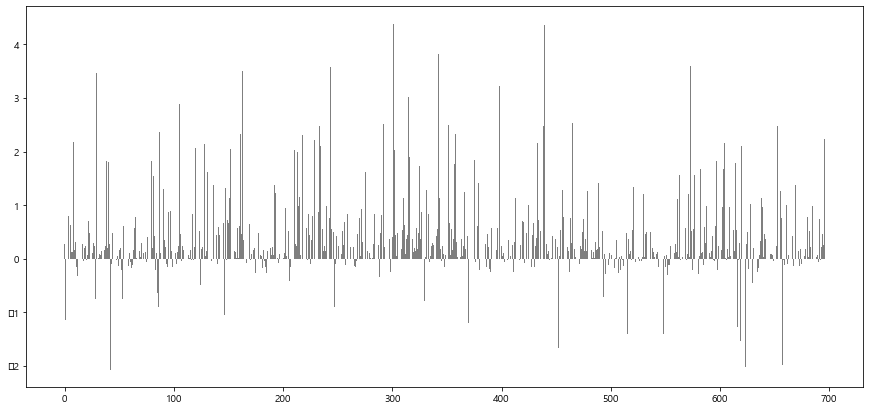

In [44]:
plt.figure(figsize = (15,7))
difference = np.log(submission_1.iloc[:int(len(submission_1) / 2),-1]) - np.log(submission.iloc[:int(len(submission) / 2),-1])
plt.bar(np.arange(len(submission_1)/2), difference,
        alpha = 0.5,
        color = 'black')
#plt.bar(np.arange(len(submission)/2), np.log(submission.iloc[:int(len(submission) / 2),-1]), alpha = 0.5, color = 'blue')

In [45]:
dif_index = []
for i in range(len(difference)):
    if (difference[i] > 1) or (difference[i] < -0.5):
        dif_index.append(i)
    else:
        pass
dif_index

[1,
 4,
 8,
 14,
 15,
 28,
 29,
 35,
 38,
 40,
 42,
 45,
 46,
 53,
 56,
 79,
 81,
 85,
 86,
 87,
 90,
 105,
 110,
 120,
 122,
 127,
 128,
 131,
 135,
 136,
 138,
 146,
 147,
 151,
 152,
 161,
 163,
 165,
 172,
 176,
 187,
 192,
 193,
 199,
 208,
 210,
 213,
 215,
 218,
 219,
 220,
 228,
 229,
 231,
 233,
 234,
 243,
 247,
 269,
 275,
 292,
 295,
 299,
 301,
 302,
 310,
 315,
 316,
 317,
 325,
 329,
 331,
 342,
 343,
 351,
 357,
 358,
 366,
 370,
 372,
 373,
 374,
 375,
 377,
 379,
 398,
 413,
 414,
 415,
 418,
 424,
 425,
 433,
 438,
 439,
 445,
 452,
 456,
 465,
 479,
 481,
 489,
 493,
 496,
 500,
 506,
 515,
 521,
 527,
 530,
 534,
 541,
 545,
 548,
 556,
 561,
 563,
 571,
 573,
 577,
 578,
 579,
 582,
 597,
 603,
 604,
 614,
 616,
 619,
 620,
 623,
 627,
 628,
 638,
 644,
 645,
 650,
 653,
 655,
 657,
 661,
 668,
 669,
 670,
 671,
 679,
 684,
 696]

In [46]:
len(dif_index)

148

In [47]:
len(difference)

697

In [49]:
submission.iloc[dif_index,:]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
1,202004,강원,골프장 운영업,1.161764e+10
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,1.770000e+05
8,202004,강원,기타 수상오락 서비스업,2.934578e+04
14,202004,강원,면세점,1.781588e+04
15,202004,강원,버스 운송업,1.689781e+05
...,...,...,...,...
670,202004,충북,면세점,5.019738e+04
671,202004,충북,버스 운송업,1.411869e+04
679,202004,충북,여행사업,6.030816e+04


In [53]:
submission_1.iloc[dif_index,:]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
1,202004,강원,골프장 운영업,3.691674e+09
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00
8,202004,강원,기타 수상오락 서비스업,2.612614e+05
14,202004,강원,면세점,0.000000e+00
15,202004,강원,버스 운송업,0.000000e+00
...,...,...,...,...
670,202004,충북,면세점,0.000000e+00
671,202004,충북,버스 운송업,0.000000e+00
679,202004,충북,여행사업,0.000000e+00
